In [31]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [32]:
# read in dataset Jill
dset = pd.read_csv('ArnarFirstSequence.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

12698
21.163333333333334


In [33]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
#d = pd.DataFrame(data = dset[0:25000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/10) # add timestamp assuming 10 samples / second
#print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

d['bmav'] = d['belly'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])
d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])
d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

d['brmav'] = d['brlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['bfmav'] = d['bflast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['brfmav'] = (d['brmav']+ d['bfmav'])/2

#Breathing rate averages Chest and Belly
d['cbrfmav'] = d['brfmav']*0.1+d['rfmav']*0.9

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

In [34]:
f = d

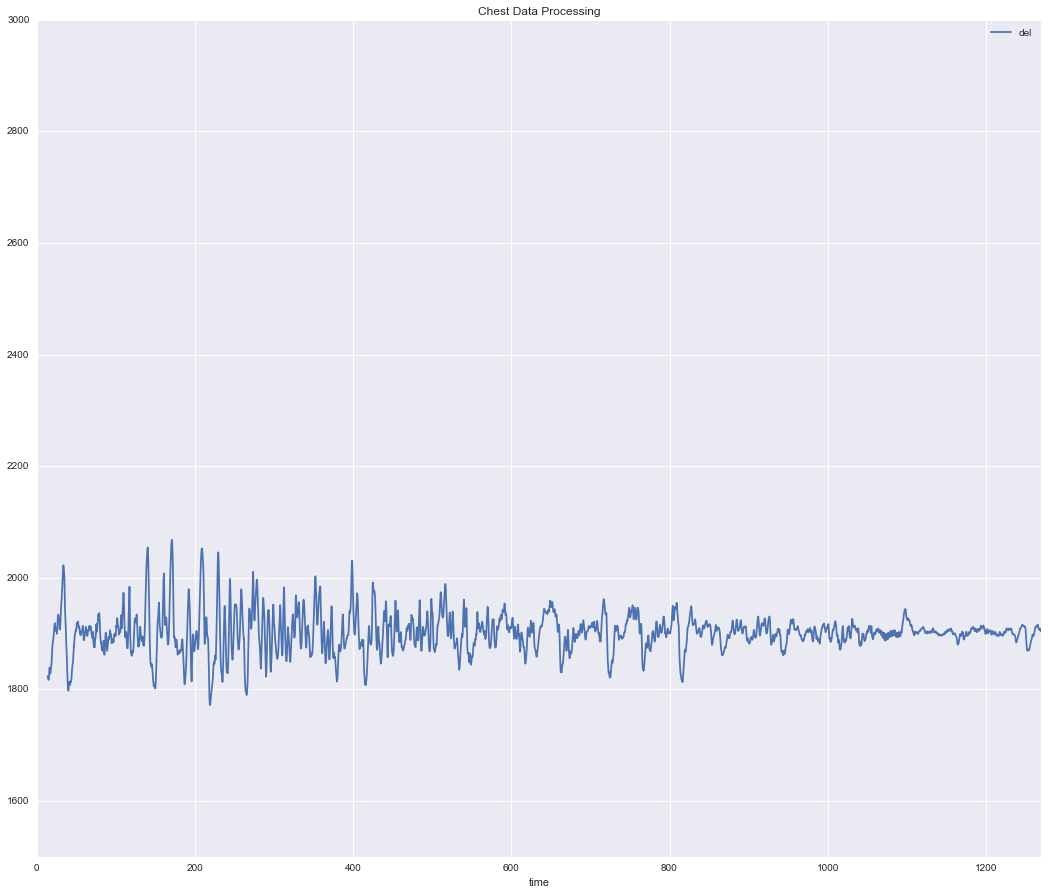

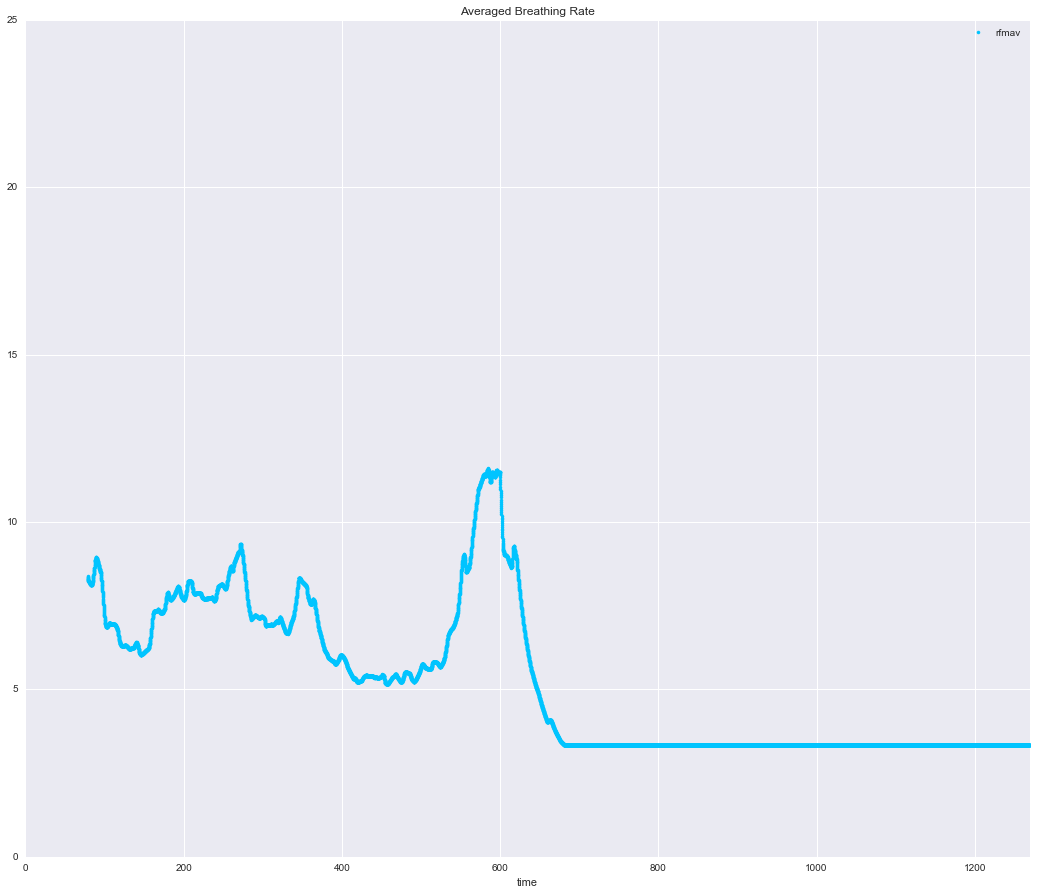

In [35]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1500,3000), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
#d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
#d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [36]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy    gz    time  ...   \
0          0   2582   2703  270 -106  716 -5438  4527  3614     0.0  ...    
1000    1000   2553   2592  -40  520  387  -563  5676  3963   100.0  ...    
2000    2000   2660   2540  104   48  671 -6751  1334  1168   200.0  ...    
3000    3000   2610   2643  -26 -298  361 -2687  1656  1375   300.0  ...    
4000    4000   2657   2707  143 -365  507 -4195  -720  2271   400.0  ...    
5000    5000   2819   2898    0  440  540  -907  1402   648   500.0  ...    
6000    6000   2945   2997   63 -404  383  -759 -2357   -66   600.0  ...    
7000    7000   2964   3014   80  -84  636  -106  -105   214   700.0  ...    
8000    8000   2964   2955  104  -77  633  -242  -445  1418   800.0  ...    
9000    9000   2997   2984   63 -410  396  -638 -1882   227   900.0  ...    
10000  10000   3015   2990   99 -409  476  2957 -1448    26  1000.0  ...    
11000  11000   3049   3062   60  544  384 -2380  1542  1128  1100.0  ...    

In [37]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fmav,rfmav,brmav,bfmav,brfmav,cbrfmav,acc,gyr,b1,b2
0,0,2582,2703,270,-106,716,-5438,4527,3614,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,596792,63126569,1900,1600
1,1,2573,2696,94,-133,659,-4236,4788,2987,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,460806,49790809,1900,1600
2,2,2589,2706,35,-177,636,-3147,768,1985,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,437050,14433658,1900,1600
3,3,2611,2722,52,-173,624,-2525,-327,2293,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,422009,11740403,1900,1600
4,4,2622,2733,57,-205,632,-1935,-129,2436,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,444698,9694962,1900,1600
5,5,2619,2745,71,-208,615,-1282,-272,1684,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,426530,4553364,1900,1600
6,6,2636,2749,56,-193,595,-717,-689,1871,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,394410,4489451,1900,1600
7,7,2649,2746,67,-200,604,-858,239,1551,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,409305,3198886,1900,1600
8,8,2644,2746,23,-189,598,-656,1165,1202,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,393854,3232365,1900,1600
9,9,2657,2749,17,-208,608,-813,1183,1303,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,413217,3758267,1900,1600
